<h2> Filter-Based Feature Selection

<h3> Database

In [27]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

In [28]:
ds = pd.read_csv("drebin.csv", low_memory=False)

In [29]:
ds.head()


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,0,0,0
4,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Training Data

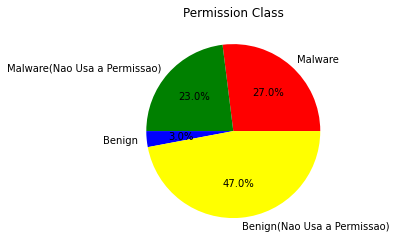

Total de Permissoes:  11120


In [30]:
def gpc(class_name, validator):
    count = 0
    j = 0
    if validator == 0:
        for i in ds[class_name]:
            if i == 1 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count
    if validator == 1:
        for i in ds[class_name]:
            if i == 0 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count
    if validator == 2:
        for i in ds[class_name]:
            if i == 1 and ds["class"][j] == 0:
                count += 1
            j += 1
        return count
    if validator == 3:
        for i in ds[class_name]:
            if i == 0 and ds["class"][j] == 0:
                count += 1
            j += 1
        return count
    if validator == 4:
        return len(ds[class_name])
    if validator == 5:
        for i in ds["class"]:
            if i == 1:
                count += 1
        return count
    if validator == 6:
        for i in ds["class"]:
            if i == 0:
                count += 1
        return count
    if validator == 7:
        return len(ds[class_name][ds[class_name] == 1])
    if validator == 8:
        return len(ds[class_name][ds[class_name] == 0])

def show_graph(class_name):
    permission_class = [gpc(class_name, 0), gpc(class_name, 1), gpc(class_name, 2), gpc(class_name, 3)]
    labels = ["Malware", "Malware(Nao Usa a Permissao)", "Benign" , "Benign(Nao Usa a Permissao)"]
    colors = ["red", "green", "blue", "yellow"]
    plt.pie(permission_class, labels=labels, colors=colors, autopct="%1.1f%%")
    plt.title("Permission Class")
    plt.show()

show_graph("SEND_SMS")
print("Total de Permissoes: ", gpc("SEND_SMS", 4))

<h3> Odds ratio

In [31]:
def od(class_name):
    return (gpc(class_name, 0) + gpc(class_name, 3)) / (gpc(class_name, 1) + gpc(class_name, 2))

od_df = pd.DataFrame(columns=["permission", "od"])
for i in ds.columns:
    if i != "class":
        od_df = pd.concat([od_df, pd.DataFrame([[i, od(i)]], columns=["permission", "od"])])

od_df.sort_values(by="od", ascending=False).head(10)

,permission,od
0,SEND_SMS,2.847751
0,READ_PHONE_STATE,2.375835
0,android.telephony.SmsManager,2.072672
0,android.intent.action.BOOT_COMPLETED,1.953519
0,RECEIVE_SMS,1.920935
0,READ_SMS,1.865241
0,TelephonyManager.getLine1Number,1.749753
0,TelephonyManager.getSubscriberId,1.518686
0,TelephonyManager.getDeviceId,1.451499
0,WRITE_SMS,1.429008


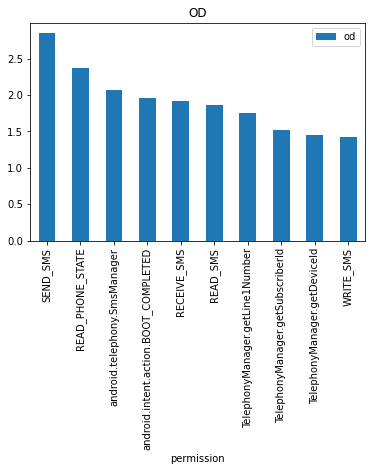

In [32]:
def show_od_graph():
    od_df.sort_values(by="od", ascending=False, inplace=True)
    od_df.head(10).plot(x="permission", y="od", kind="bar")
    plt.title("OD")
    plt.show()

show_od_graph()


<h3> Chi-Square

In [33]:
def chi_squared(class_name):
    a = gpc(class_name, 0)
    b = gpc(class_name, 1)
    c = gpc(class_name, 2)
    d = gpc(class_name, 3)
    return ((a*d - b*c)**2) / ((a+b)*(c+d)*(a+c)*(b+d))

chi_squared_df = pd.DataFrame(columns=["permission", "chi_squared"])
for i in ds.columns:
    if i != "class":
        chi_squared_df = pd.concat([chi_squared_df, pd.DataFrame([[i, chi_squared(i)]], columns=["permission", "chi_squared"])])
chi_squared_df.sort_values(by="chi_squared", ascending=False).head(10)

,permission,chi_squared
0,transact,0.368337
0,onServiceConnected,0.353343
0,bindService,0.3518
0,ServiceConnection,0.349351
0,attachInterface,0.345661
0,android.os.Binder,0.332772
0,SEND_SMS,0.27491
0,Ljava.lang.Class.getCanonicalName,0.258042
0,Ljava.lang.Class.cast,0.234169
0,Ljava.lang.Class.getMethods,0.23044


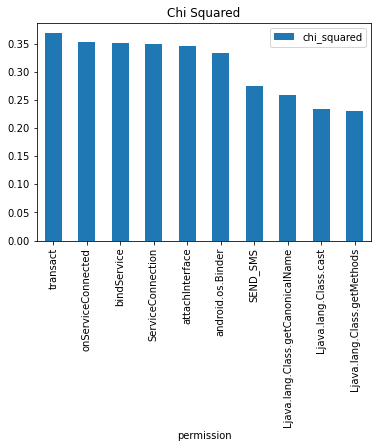

In [34]:
def show_chi_squared_graph():
    chi_squared_df.sort_values(by="chi_squared", ascending=False, inplace=True)
    chi_squared_df.head(10).plot(x="permission", y="chi_squared", kind="bar")
    plt.title("Chi Squared")
    plt.show()

show_chi_squared_graph()

<h3> Inverse Document Frequency

In [35]:
def idf(class_name):
    return np.log(gpc(class_name,4) / (gpc(class_name, 0) + gpc(class_name, 2)))

idf_df = pd.DataFrame(columns=["permission", "idf"])
for i in ds.columns:
    if i != "class":
        idf_df = pd.concat([idf_df, pd.DataFrame([[i, idf(i)]], columns=["permission", "idf"])])

idf_df.sort_values(by="idf", ascending=False).head(10)

,permission,idf
0,Runtime.loadLibrary,7.524741
0,BIND_VPN_SERVICE,7.37059
0,SET_ACTIVITY_WATCHER,7.237059
0,BIND_TEXT_SERVICE,6.60845
0,INSTALL_LOCATION_PROVIDER,6.543912
0,ADD_VOICEMAIL,6.543912
0,Process.start,6.372062
0,MOUNT_FORMAT_FILESYSTEMS,6.320768
0,android.intent.action.CALL_BUTTON,6.271978
0,Context.bindService,6.225458


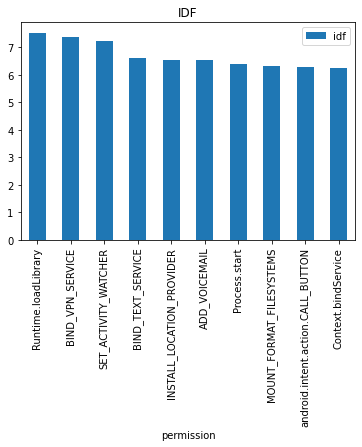

In [36]:
def show_idf_graph():
    idf_df.sort_values(by="idf", ascending=False, inplace=True)
    idf_df.head(10).plot(x="permission", y="idf", kind="bar")
    plt.title("IDF")
    plt.show()

show_idf_graph()

<h3> Document Frequency Threshold

In [37]:
def dft(class_name):
    return gpc(class_name,0) + gpc(class_name,2)

dft_df = pd.DataFrame(columns=["permission", "dft"])
for i in ds.columns:
    if i != "class":
        dft_df = pd.concat([dft_df, pd.DataFrame([[i, dft(i)]], columns=["permission", "dft"])])
dft_df.sort_values(by="dft", ascending=False).head(10)

,permission,dft
0,INTERNET,9902
0,Binder,8511
0,IBinder,8440
0,android.os.IBinder,8440
0,ACCESS_NETWORK_STATE,7908
0,Ljava.lang.Object.getClass,7753
0,READ_PHONE_STATE,7626
0,onBind,7521
0,WRITE_EXTERNAL_STORAGE,7407
0,HttpUriRequest,7059


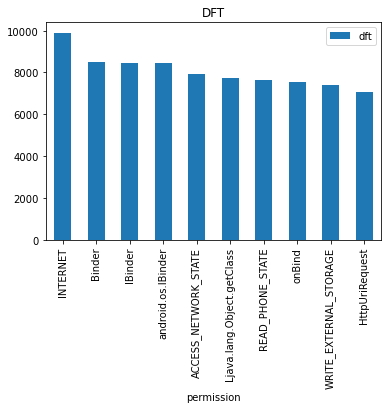

In [38]:
def show_dft_graph():
    dft_df.sort_values(by="dft", ascending=False, inplace=True)
    dft_df.head(10).plot(x="permission", y="dft", kind="bar")
    plt.title("DFT")
    plt.show()

show_dft_graph()

<h3> Acc and Acc2

In [39]:
def acc(class_name):
    return gpc(class_name,0) - gpc(class_name,3)

def acc2(class_name):
    return (gpc(class_name,0)/gpc(class_name,5)) - (gpc(class_name,2)/gpc(class_name,6))

acc_df = pd.DataFrame(columns=["permission", "acc"])
for i in ds.columns:
    if i != "class":
        acc_df = pd.concat([acc_df, pd.DataFrame([[i, acc(i)]], columns=["permission", "acc"])])
acc_df.sort_values(by="acc", ascending=False).head(10)

,permission,acc
0,INTERNET,4342
0,Binder,2951
0,IBinder,2880
0,android.os.IBinder,2880
0,ACCESS_NETWORK_STATE,2348
0,Ljava.lang.Object.getClass,2193
0,READ_PHONE_STATE,2066
0,onBind,1961
0,WRITE_EXTERNAL_STORAGE,1847
0,HttpUriRequest,1499


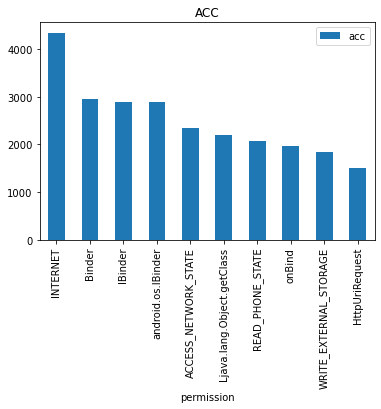

In [40]:
def show_acc_graph():
    acc_df.sort_values(by="acc", ascending=False, inplace=True)
    acc_df.head(10).plot(x="permission", y="acc", kind="bar")
    plt.title("ACC")
    plt.show()

show_acc_graph()

In [41]:
acc2_df = pd.DataFrame(columns=["permission", "acc2"])
for i in ds.columns:
    if i != "class":
        acc2_df = pd.concat([acc2_df, pd.DataFrame([[i, acc2(i)]], columns=["permission", "acc2"])])
acc2_df.sort_values(by="acc2", ascending=False).head(10)


,permission,acc2
0,SEND_SMS,0.480216
0,READ_PHONE_STATE,0.407554
0,android.telephony.SmsManager,0.349101
0,android.intent.action.BOOT_COMPLETED,0.322842
0,RECEIVE_SMS,0.315288
0,READ_SMS,0.301978
0,TelephonyManager.getLine1Number,0.272662
0,TelephonyManager.getSubscriberId,0.205935
0,TelephonyManager.getDeviceId,0.184173
0,WRITE_SMS,0.176619


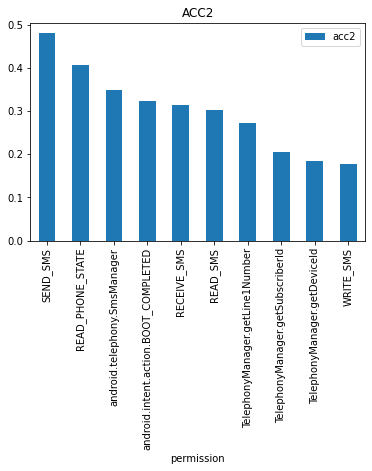

In [42]:
def show_acc2_graph():
    acc2_df.sort_values(by="acc2", ascending=False, inplace=True)
    acc2_df.head(10).plot(x="permission", y="acc2", kind="bar")
    plt.title("ACC2")
    plt.show()

show_acc2_graph()

<h3> M2 Method

In [44]:
def m2(class_name):
    return dft(class_name) * (np.absolute(gpc(class_name,0)/gpc(class_name,7) - (gpc(class_name,1)/gpc(class_name,8))))

m2_df = pd.DataFrame(columns=["permission", "m2"])
for i in ds.columns:
    if i != "class":
        m2_df = pd.concat([m2_df, pd.DataFrame([[i, m2(i)]], columns=["permission", "m2"])])
m2_df.sort_values(by="m2", ascending=False).head(10)

,permission,m2
0,READ_PHONE_STATE,3605.884373
0,INTERNET,3551.461412
0,android.os.Binder,2669.138508
0,onServiceConnected,2528.714001
0,ServiceConnection,2508.568175
0,bindService,2505.19359
0,transact,2460.983607
0,attachInterface,2327.529476
0,android.content.pm.PackageInfo,2280.331223
0,ClassLoader,2147.799798


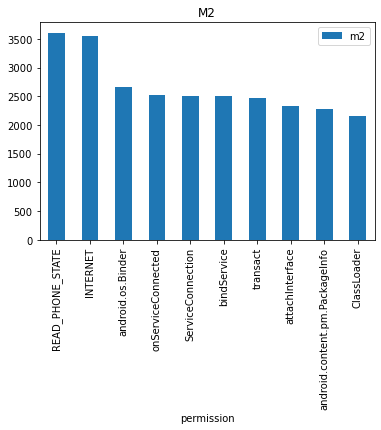

In [45]:
def show_m2_graph():
    m2_df.sort_values(by="m2", ascending=False, inplace=True)
    m2_df.head(10).plot(x="permission", y="m2", kind="bar")
    plt.title("M2")
    plt.show()

show_m2_graph()

<h3> Relevance frequency feature selection

In [46]:
def rffs(class_name):
    return dft(class_name) * np.absolute(np.log(2 + (gpc(class_name,0)/gpc(class_name,2))))

rffs_df = pd.DataFrame(columns=["permission", "rffs"])
for i in ds.columns:
    if i != "class":
        rffs_df = pd.concat([rffs_df, pd.DataFrame([[i, rffs(i)]], columns=["permission", "rffs"])])
rffs_df.sort_values(by="rffs", ascending=False).head(10)

,permission,rffs
0,INTERNET,11425.934433
0,READ_PHONE_STATE,10271.531507
0,Binder,8748.460309
0,android.os.IBinder,8697.967265
0,IBinder,8697.967265
0,ACCESS_NETWORK_STATE,8338.568252
0,WRITE_EXTERNAL_STORAGE,8168.887713
0,onBind,8111.747992
0,SEND_SMS,8014.957741
0,Ljava.lang.Object.getClass,7815.523399


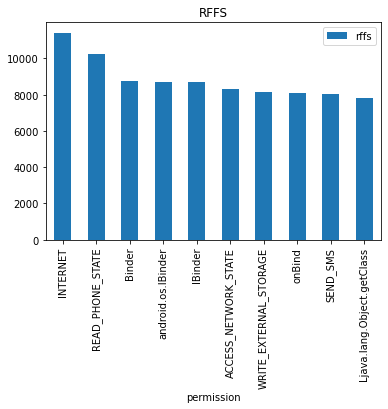

In [47]:
def show_rffs_graph():
    rffs_df.sort_values(by="rffs", ascending=False, inplace=True)
    rffs_df.head(10).plot(x="permission", y="rffs", kind="bar")
    plt.title("RFFS")
    plt.show()

show_rffs_graph()

<h3> Information Gain

In [49]:
def ppc(class_name, validator):
    count = 0
    j = 0
    if validator == 1:
        return gpc(class_name,5)/len(ds)
    elif validator == 2:
        for i in ds[class_name]:
            if i == 1:
                count += 1
        return count/len(ds)
    elif validator == 3:
        for i in ds[class_name]:
            if i == 0:
                count += 1
        return count/len(ds)
    elif validator == 4:
        for i in ds[class_name]:
            if i == 1 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count/len(ds)
    elif validator == 5:
        for i in ds[class_name]:
            if i == 0 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count/len(ds)

In [51]:
def ig(class_name):
    pc = ppc(class_name,1)
    pp = ppc(class_name,2)
    pnp = ppc(class_name,3)
    pcp = ppc(class_name,4)
    pcnp = ppc(class_name,5)
    #−∑Ci=1P(ci)logP(ci) + P(p)∑Ci=1P(ci|p)logP(ci|p) + P(p̄)∑Ci=1P(ci|p̄)logP(ci|p̄) convert to a function
    # return -pc * np.log2(pc) + pp * np.log2(pp) + pnp * np.log2(pnp) + pcp * np.log2(pcp) + pcnp * np.log2(pcnp)

ig_df = pd.DataFrame(columns=["permission", "ig"])
for i in ds.columns:
    if i != "class":
        ig_df = pd.concat([ig_df, pd.DataFrame([[i, ig(i)]], columns=["permission", "ig"])])
ig_df.sort_values(by="ig", ascending=False).head(10)

C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykernel_21800\3098020480.py:8: RuntimeWarning: divide by zero encountered in log2
  return -pc*np.log2(pc) + pp*np.log2(pcp) + pnp*np.log2(pcnp)
C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykernel_21800\3098020480.py:8: RuntimeWarning: divide by zero encountered in log2
  return -pc*np.log2(pc) + pp*np.log2(pcp) + pnp*np.log2(pcnp)
C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykernel_21800\3098020480.py:8: RuntimeWarning: divide by zero encountered in log2
  return -pc*np.log2(pc) + pp*np.log2(pcp) + pnp*np.log2(pcnp)
C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykernel_21800\3098020480.py:8: RuntimeWarning: divide by zero encountered in log2
  return -pc*np.log2(pc) + pp*np.log2(pcp) + pnp*np.log2(pcnp)
C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykernel_21800\3098020480.py:8: RuntimeWarning: divide by zero encountered in log2
  return -pc*np.log2(pc) + pp*np.log2(pcp) + pnp*np.log2(pcnp)
C:\Users\Nicolas - ICTS\AppData\Local\Temp\ipykern

,permission,ig
0,SET_ACTIVITY_WATCHER,-0.50921
0,INSTALL_LOCATION_PROVIDER,-0.51816
0,MOUNT_FORMAT_FILESYSTEMS,-0.520302
0,android.intent.action.CALL_BUTTON,-0.522124
0,CLEAR_APP_USER_DATA,-0.524509
0,intent.action.RUN,-0.525448
0,SET_PROCESS_LIMIT,-0.525991
0,ACCESS_SURFACE_FLINGER,-0.526774
0,BIND_ACCESSIBILITY_SERVICE,-0.531585
0,INTERNAL_SYSTEM_WINDOW,-0.53211


In [ ]:
def show_ig_graph():
    ig_df.sort_values(by="ig", ascending=False, inplace=True)
    ig_df.head(10).plot(x="permission", y="ig", kind="bar")
    plt.title("IG")
    plt.show()

show_ig_graph()